In [11]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import ipywidgets as widgets
from IPython.display import display
from sklearn.neighbors import NearestNeighbors
import time

In [13]:
# 两条墙的四次多项式方程
def right_wall(x):
    # 右侧墙的四次方程
    return -(-5.241e-07 * x ** 4 + 0.0009059 * x ** 3 - 0.5874 * x ** 2 + 170 * x ** 1 - 1.82e+04 - 300) + 300


def left_wall(x):
    # 左侧墙的四次方程
    return 7.342e-07 * x ** 4 - 0.000102 * x ** 3 + 0.01065 * x ** 2 + 0.4626 * x + 184

In [14]:
train_num = 100


def read_sonar_data(file_path):
    # Read sonar beam data from a .dat file and return a matrix of image data
    valid_ping_num = train_num  # Number of valid pings
    num_IMG = 307200  # Total image data points per ping

    img_8bit_matrix = np.zeros(
        (num_IMG, valid_ping_num), dtype=np.uint8
    )  # Initialize the output matrix

    with open(file_path, "rb") as file:
        file.read(40)  # Read and discard the file header (10 uint32)

        # Fixed header search
        c1 = struct.unpack("B", file.read(1))[0]
        c2 = struct.unpack("B", file.read(1))[0]
        c3 = struct.unpack("B", file.read(1))[0]
        for k in range(valid_ping_num):
            if file.read(0) == "b":
                break
            # Header search within 64k
            for kk in range(65535):
                c4 = struct.unpack("B", file.read(1))[0]
                if c4 == ord("O") and c3 == ord("S") and c2 == 0 and c1 == 0:
                    break
                c1, c2, c3 = c2, c3, c4

                if file.read(0) == "b":
                    return img_8bit_matrix

            if kk == 65535:
                return img_8bit_matrix
            file.read(14)  # Read and discard SHeaderStr

            mode = np.frombuffer(file.read(5), dtype=np.uint8)
            range_percent = struct.unpack("d", file.read(8))[0]
            gain_percent = struct.unpack("d", file.read(8))[0]
            speed_of_sound = struct.unpack("d", file.read(8))[0]
            salinity = struct.unpack("d", file.read(8))[0]
            ext_flags = struct.unpack("I", file.read(4))[0]
            reserved = np.frombuffer(file.read(32), dtype=np.uint32)

            num_dat16 = reserved[4]  # Sample points
            chn_dat16 = reserved[5]  # Channels

            ping_id = struct.unpack("I", file.read(4))[0]
            status = np.frombuffer(file.read(69), dtype=np.uint8)
            range_resolution = struct.unpack("d", file.read(8))[0]
            n_ranges = struct.unpack("H", file.read(2))[0]
            n_beams = struct.unpack("H", file.read(2))[0]
            file.read(28)  # Read and discard spare

            # Update sample points and beams
            num_sam = n_ranges
            num_beam = float(n_beams)

            file.read(1024)  # Read and discard beam angles (512 int16)
            file.read(822)  # Read and discard tem16 (411 uint16)

            # Read image data
            img_8bit = np.frombuffer(file.read(num_IMG), dtype=np.uint8)
            img_8bit_matrix[:, k] = img_8bit

    return img_8bit_matrix


def reshape_img_matrix(img_8bit_matrix):
    # Ensure img_8bit_matrix has the shape (307200, 500)
    if img_8bit_matrix.shape != (307200, train_num):
        raise ValueError("img_8bit_matrix must have shape (307200, 500)")

    # Reshape each column into a (600, 512) array
    reshaped_arrays = np.empty((600, 512, img_8bit_matrix.shape[1]), dtype=np.uint8)

    for k in range(img_8bit_matrix.shape[1]):
        reshaped_arrays[:, :, k] = img_8bit_matrix[:, k].reshape((600, 512))

    return reshaped_arrays


def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


def plot_sonar_slice(ans, k):
    slice_data = ans[:, :, k]
    normalized_data = normalize_data(slice_data)
    plt.imshow(normalized_data, cmap="jet", vmin=0, vmax=1)
    plt.colorbar(label="Echo Intensity (Normalized)")
    plt.title(f"Sonar Echo Intensity for Slice {k} (Normalized)")
    plt.xlabel("Column Index (j)")
    plt.ylabel("Row Index (i)")


# 生成标签，墙体附近的点设为异常，labels为二维矩阵
def generate_labels(data_shape, threshold=5, k_neighbors=5, anomaly_ratio=0.5):
    labels = torch.zeros(data_shape[0], data_shape[1])  # 二维的标签矩阵

    # 遍历每一个像素点，根据x坐标判断其是否靠近墙
    for i in range(data_shape[0]):  # 遍历行
        for j in range(data_shape[1]):  # 遍历列
            x_coord = j  # x坐标为图像的列索引
            right_y = right_wall(x_coord)
            left_y = left_wall(x_coord)

            if (right_y - threshold <= i <= right_y + threshold) or (
                left_y - threshold <= i <= left_y + threshold
            ):
                labels[i, j] = 1  # 标记为异常点

    # 将 PyTorch 张量转换为 NumPy 数组，以便后续进行 KNN 操作
    labels_np = labels.clone().numpy()

    # 使用 KNN 扩展异常点检测
    X, Y = np.meshgrid(np.arange(data_shape[1]), np.arange(data_shape[0]))
    coordinates = np.vstack((Y.ravel(), X.ravel())).T

    nn_model = NearestNeighbors(n_neighbors=k_neighbors)
    nn_model.fit(coordinates)

    anomaly_indices = np.argwhere(labels_np == 1)
    distances, neighbors = nn_model.kneighbors(anomaly_indices)

    for i, point in enumerate(anomaly_indices):
        neighbor_points = neighbors[i]
        anomaly_count = np.sum(
            labels_np[coordinates[neighbor_points, 0], coordinates[neighbor_points, 1]]
            == 1
        )
        if anomaly_count / k_neighbors >= anomaly_ratio:
            labels_np[point[0], point[1]] = 1  # 更新为异常点

    return torch.tensor(labels_np)


# 可视化结果
def plot_anomalies(original_data, predictions, slice_idx):
    original_img = original_data[slice_idx, 0, :, :].cpu().numpy()
    prediction_mask = predictions[slice_idx, 0, :, :].cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap="gray")
    plt.title(f"Original Image (Slice {slice_idx})")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(original_img, cmap="gray")
    plt.imshow(prediction_mask, cmap="Reds", alpha=0.5)
    plt.title(f"Predicted Anomalies (Slice {slice_idx})")
    plt.colorbar()
    plt.show()


# 添加交互式功能
def interactive_plot(ans_tensor, predictions):
    def update_plot(slice_idx):
        plot_anomalies(ans_tensor, predictions, slice_idx)

    slice_slider = widgets.IntSlider(
        value=0, min=0, max=20 - 1, step=1, description="Slice:"
    )
    widgets.interact(update_plot, slice_idx=slice_slider)
# 绘制叠加的原始数据和标签
def plot_data_with_labels(data, labels):
    plt.figure(figsize=(8, 6))

    # 绘制原始数据
    plt.imshow(data, cmap="gray", interpolation="none")

    # 绘制标签，使用半透明效果
    plt.imshow(labels, cmap="autumn", interpolation="none", alpha=0.5)

    plt.colorbar(label="Anomaly Label")
    plt.title("Original Data with Anomaly Labels")
    plt.xlabel("X-axis (Image Width)")
    plt.ylabel("Y-axis (Image Height)")
    plt.show()

# 准备数据和标签
def prepare_data_and_labels(ans):
    data = np.moveaxis(ans, -1, 0)
    data = np.expand_dims(data, axis=1)
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    data_tensor = torch.tensor(data, dtype=torch.float32)

    # 生成二维标签矩阵
    labels_tensor = generate_labels(data_tensor.shape[2:])
    
    # 绘制叠加的原始数据和标签
    plot_data_with_labels(data_tensor[0, 0].numpy(), labels_tensor.numpy())

    # 将二维标签扩展为与数据相同的三维尺寸
    labels_tensor = labels_tensor.unsqueeze(0).expand(data_tensor.shape[0], -1, -1)
    labels_tensor = labels_tensor.unsqueeze(1)

    return data_tensor, labels_tensor


In [15]:
# 训练卷积神经网络，使用二元交叉熵损失
def train_supervised_model(model, data, labels, num_epochs=min(30, train_num), batch_size=16, learning_rate=0.001):
    print("Training supervised model...")
    criterion = nn.BCELoss()  # 二元交叉熵损失
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    data_loader = torch.utils.data.DataLoader(list(zip(data, labels)), batch_size=batch_size, shuffle=True)
    t = time.time()
    for epoch in range(num_epochs):
        for batch_data, batch_labels in data_loader:
            output = model(batch_data)
            loss = criterion(output, batch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        t1 = time.time()
        if ((epoch + 1) % 10 == 0) or t1 - t > 5:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Time: {t1 - t}')
            t = t1

In [16]:
import torch
import torch.nn as nn

# 卷积神经网络模型
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # 编码器部分
        self.encoder1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),  # 使用不同的卷积核大小
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.encoder3 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=7, stride=1, padding=3),  # 再增加一个并行层
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.encoder4 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=9, stride=1, padding=4),  # 继续增加
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.encoder5 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=11, stride=1, padding=5),  # 再增加一个
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.encoder6 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=13, stride=1, padding=6),  # 最后一个并行层
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.encoder3_combined = nn.Sequential(
            nn.Conv2d(16 * 6, 32, kernel_size=3, stride=1, padding=1),  # 更新为输入通道数为并行输出的总和
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # 解码器部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 并行编码
        encoded1 = self.encoder1(x)
        encoded2 = self.encoder2(x)
        encoded3 = self.encoder3(x)
        encoded4 = self.encoder4(x)
        encoded5 = self.encoder5(x)
        encoded6 = self.encoder6(x)

        # 将所有编码器的输出拼接在一起
        encoded = torch.cat((encoded1, encoded2, encoded3, encoded4, encoded5, encoded6), dim=1)  # 在通道维度拼接

        # 继续编码
        encoded = self.encoder3_combined(encoded)

        # 解码过程
        decoded = self.decoder(encoded)
        return decoded


In [17]:
# 一层并行
import torch
import torch.nn as nn

# 卷积神经网络模型
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 编码器部分
        self.encoder1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=15, stride=1, padding=7),  # 使用不同的卷积核大小
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 使用不同的卷积核大小
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # self.encoder3 = nn.Sequential(
        #     nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2)
        # )

        # 解码器部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(192, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            # nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            # nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 并行编码
        encoded1 = self.encoder1(x)
        encoded2 = self.encoder2(x)

        # 将两个编码器的输出拼接在一起
        encoded = torch.cat((encoded1, encoded2), dim=1)  # 在通道维度拼接

        # 继续编码
        # encoded = self.encoder3(encoded)

        # 解码过程
        decoded = self.decoder(encoded)
        return decoded


In [48]:
# 一层并行 & dropout
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 编码器部分
        self.encoder1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # nn.Dropout(0.25)  # 加入Dropout层，丢弃率为25%
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=15, stride=1, padding=7),  # 使用不同的卷积核大小
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # nn.Dropout(0.25)  # 加入Dropout层，丢弃率为25%
        )

        self.encoder3 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # 使用不同的卷积核大小
            nn.ReLU(),
            nn.MaxPool2d(4, 4),
        )


        self.encoder4 = nn.Sequential(
            nn.Conv2d(80, 80, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # nn.Dropout(0.25)  # 加入Dropout层
        )

        # 解码器部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(80, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 并行编码
        encoded1 = self.encoder1(x)
        encoded2 = self.encoder2(x)
        encoded3 = self.encoder3(x)

        # 将两个编码器的输出拼接在一起
        encoded = torch.cat((encoded1, encoded2, encoded3), dim=1)  # 在通道维度拼接

        # 继续编码
        encoded = self.encoder4(encoded)

        # 解码过程
        decoded = self.decoder(encoded)
        return decoded


In [33]:
# origin model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # 解码器部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


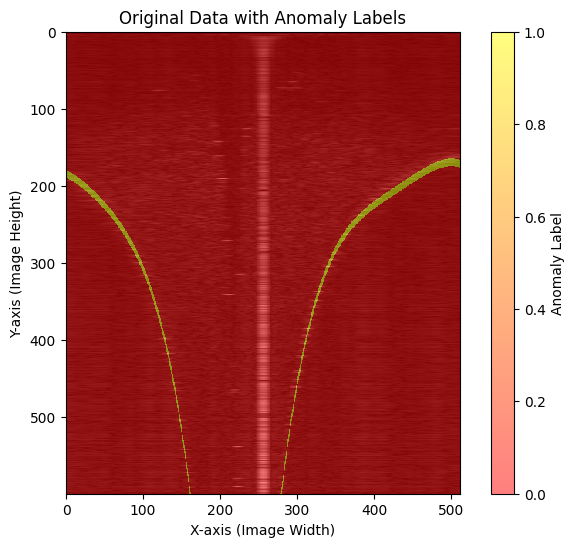

In [18]:
# Read and reshape image data
file_path = "./data/go22-26m.dat"
img_8bit_matrix = read_sonar_data(file_path)
ans = reshape_img_matrix(img_8bit_matrix)  # ans为最后读出来的三维数组

# 加载数据并生成标签
ans_tensor, labels_tensor = prepare_data_and_labels(ans)

In [19]:
# 初始化卷积网络
conv_net = ConvNet()
# 检查 GPU 是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 加载预训练模型的权重
conv_net.load_state_dict(torch.load('./model/smallmodeland.pth'))
# 将模型移动到 GPU
conv_net.to(device)
# 将数据和标签移动到 GPU
ans_tensor = ans_tensor.to(device)
labels_tensor = labels_tensor.to(device)

In [24]:
num_epochs = 10
for i in range(10):
    # 开始训练卷积神经网络
    train_supervised_model(conv_net, ans_tensor, labels_tensor, num_epochs, learning_rate = 0.01)
    # 保存模型参数
    torch.save(conv_net.state_dict(), "./model/smallmodeland.pth")

Training supervised model...
Epoch [2/10], Loss: 0.0308, Time: 8.24302053451538
Epoch [3/10], Loss: 0.0278, Time: 8.521328210830688
Epoch [4/10], Loss: 0.0253, Time: 5.657358169555664
Epoch [5/10], Loss: 0.0241, Time: 8.350856065750122
Epoch [6/10], Loss: 0.0236, Time: 8.492004871368408
Epoch [7/10], Loss: 0.0222, Time: 5.521497011184692
Epoch [8/10], Loss: 0.0215, Time: 7.664376497268677
Epoch [9/10], Loss: 0.0201, Time: 7.707172870635986
Epoch [10/10], Loss: 0.0194, Time: 5.285359144210815
Training supervised model...
Epoch [2/10], Loss: 0.0576, Time: 8.023999214172363
Epoch [3/10], Loss: 0.0417, Time: 8.521392107009888
Epoch [4/10], Loss: 0.0317, Time: 5.9971537590026855
Epoch [5/10], Loss: 0.0290, Time: 7.534351825714111
Epoch [6/10], Loss: 0.0266, Time: 8.037039518356323
Epoch [7/10], Loss: 0.0250, Time: 5.365199089050293
Epoch [8/10], Loss: 0.0233, Time: 7.731483459472656
Epoch [9/10], Loss: 0.0226, Time: 7.5795509815216064
Epoch [10/10], Loss: 0.0219, Time: 5.265055418014526
Tra

In [25]:
# 保存模型参数
torch.save(conv_net.state_dict(), "./model/smallmodeland.pth")

In [23]:
# 使用训练后的模型进行预测
conv_net.eval()
with torch.no_grad():
    predictions = conv_net(ans_tensor)

# 交互式显示切片和预测结果
interactive_plot(ans_tensor[0:1], predictions[0:1])


interactive(children=(IntSlider(value=0, description='Slice:', max=19), Output()), _dom_classes=('widget-inter…

In [ ]:
ans_tensor[0:10].shape

In [ ]:
import torch
from torchviz import make_dot

# 创建模型实例
conv_net = ConvNet()

# 生成一个随机输入数据
x = torch.randn(1, 1, 1200, 1024)  # 根据您的输入尺寸进行调整

# 前向传播
y = conv_net(x)

# 可视化计算图
dot = make_dot(y, params=dict(conv_net.named_parameters()))
dot.render("conv_net_architecture", format="png")  # 生成 PNG 文件
